# Introduction

fill

# Imports, configs, etc

In [5]:
import numpy as np
import pandas as pd
import datetime
import pvlib
import clearsky_detect_model_comparison
import clearsky_detect_model_free
import preprocess

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

import warnings

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

## Load data

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

In [2]:
def load_snl():
    filename = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
    cols = ['Global_Wm2', 'Date-Time']
    data = pd.read_csv(filename, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
    data.index = data.index.tz_localize('Etc/GMT+7')
    data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')).fillna(0)
    data = pd.Series(data['Global_Wm2'], index=data.index)
    data[data < 0] = 0 
    return data

In [3]:
def load_srrl():
    srrl_file = os.path.expanduser('~/data_sets/srrl/20140101.csv')
    srrl_data = pd.read_csv(srrl_file)
    srrl_data.index = pd.to_datetime(srrl_data['DATE (MM/DD/YYYY)'] + ' ' + srrl_data['MST'])
    srrl_data.index = srrl_data.index.tz_localize('Etc/GMT+7')
    srrl_data = srrl_data[~srrl_data.index.duplicated(keep='first')]
    # srrl_data = srrl_data.reindex(
    #     pd.date_range(start=srrl_data.index[0], end=srrl_data.index[-1], freq='1min')
    # ).fillna(0)
    srrl_data.drop(['DATE (MM/DD/YYYY)', 'MST'], inplace=True, axis=1)
    srrl_data = pd.Series(srrl_data['Global 40-South LI-200 [W/m^2]'], index=srrl_data.index)
    srrl_data[srrl_data < 0] = 0
    srrl_data2 = pd.Series(0, index=pd.date_range(start=srrl_data.index.date[0], end=srrl_data.index.date[-1] + pd.Timedelta('1D'), freq='1min'))
    srrl_data2.index = srrl_data2.index.tz_localize('Etc/GMT+7')
    # print(srrl_data.index[0], srrl_data.index[-1])
    # print(srrl_data.index.date[0], srrl_data.index.date[-1])
    # print(srrl_data2.index[0], srrl_data2.index[-1])
    srrl_data2[srrl_data.index] = srrl_data
    srrl_data = srrl_data2.copy()
    return srrl_data

In [4]:
snl_data = load_snl()
srrl_data = load_srrl()

## Set up PVLib systems

In [6]:
def make_pvlib_sys(tilt, elevation, azimuth, lat, lon):
    sys_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=azimuth)
    sys_loc = pvlib.location.Location(lat, lon, altitude=elevation)
    sys = pvlib.pvsystem.LocalizedPVSystem(pvsystem=sys_no_loc, location=sys_loc)
    return sys

In [7]:
snl_params = {'tilt': 35, 'elevation': 1658, 'azimuth': 180, 'lat': 35.0549, 'lon': -106.5433}
rtc = make_pvlib_sys(**snl_params)

In [8]:
srrl_params = {'tilt': 40, 'elevation': 1828.8, 'azimuth': 180, 'lat': 39.742, 'lon': -105.18}
srrl = make_pvlib_sys(**srrl_params)

## Analysis functions

In [16]:
def compare_plot(sample, is_clear, is_clear_pvlib):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 5), sharex=True)

    ax = axes[0]
    _ = ax.plot(sample.index, sample)
    _ = ax.scatter(sample.index[is_clear & ~is_clear_pvlib], sample[is_clear & ~is_clear_pvlib], 
                   facecolor='none', edgecolor='green', label='comparison')
    _ = ax.scatter(sample.index[is_clear_pvlib & ~is_clear], sample[is_clear_pvlib & ~is_clear], 
                   facecolor='none', edgecolor='red', label='pvlib')
    _ = ax.scatter(sample.index[is_clear_pvlib & is_clear], sample[is_clear & is_clear_pvlib], 
                   facecolor='none', edgecolor='orange', label='both')
    # _ = ax.scatter(sample.index[is_clear_pvlib], sample[is_clear_pvlib], 
    #                marker='.', color='black', label='pvlib')
    _ = ax.legend()
    
        
    ax = axes[1]
    _ = ax.plot(is_clear.index, np.cumsum(is_clear.astype(int)), label='comparison')
    # _ = ax.plot(is_clear_filtered.index, np.cumsum(is_clear_filtered.astype(int)), label='filtered')
    _ = ax.plot(is_clear_pvlib.index, np.cumsum(is_clear_pvlib.astype(int)), label='pvlib')
    _ = ax.legend()
    
    fig.tight_layout()

In [94]:
def metric_plot(sample, model, metric):
    fig, ax = plt.subplots()
    
    ax.plot(sample.index, sample)
    ax.plot(model.index, model)
    p = ax.scatter(metric.index, sample, c=metric, cmap=matplotlib.cm.jet)
    fig.colorbar(p)

# Investigation

## SNL RTC

In [11]:
sample = snl_data[(snl_data.index >= '2016-07-01') & (snl_data.index < '2016-07-15')]

In [160]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    clear_skies = rtc.get_clearsky(sample.index)
    clear_skies = pd.Series(clear_skies['ghi'], index=sample.index)
    is_clear_pvlib, _, alpha = pvlib.clearsky.detect_clearsky(sample, clear_skies, sample.index, 10, return_components=True)

In [180]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear_model_comparison, components = \
        clearsky_detect_model_comparison.comparison_detect(sample, alpha * clear_skies, window=30, verbose=True)

2.61803396034
2.61803396034
2.61803396034
2.61803396034
2.61803396034
2.61803396034
2.61803396034
2.61803396034
2.61803396034
2.61803396034


In [181]:
print(alpha)

0.941639659057


<IPython.core.display.Javascript object>


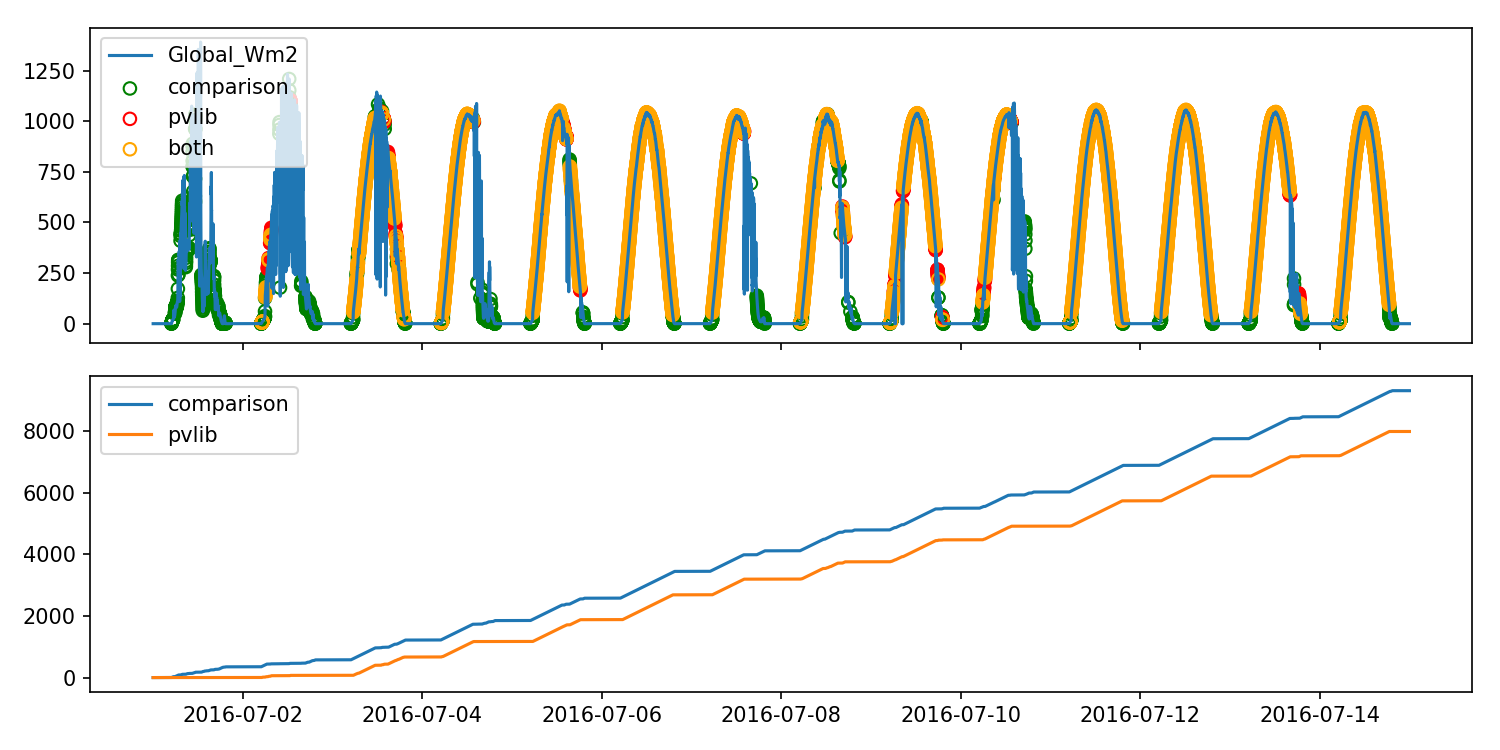

In [182]:
compare_plot(sample, is_clear_model_comparison, is_clear_pvlib)

# Conclusion




